### Import data

In [8]:
%matplotlib inline
import numpy as np
import pickle

features = ['id','bedrooms','star_rating','person_capacity','lat','lng','reviews_count']
num_features = len(features)

(price, data) = pickle.load(open("SF_3600_apts.pkl","rb"))

# ( was tested with df = pd.DataFrame(data) df.drop_duplicates() to make sure no duplicates)


### Try linear regression 

In [9]:
from sklearn import linear_model
from sklearn import cross_validation

lm = linear_model.LinearRegression()
lm = lm.fit( data, price )

scores = cross_validation.cross_val_score(lm, data, price)
print("scores =",scores)
print("avg accuracy = %4.2f" % scores.mean())

scores = [ 0.27374832  0.33804901  0.25357051]
avg accuracy = 0.29


### Try polynomial features 
try adding nth order features to investigate bias vs variance trade off 

In [3]:
def degree_n_fit(data, n):
    to_concat = [data]
    
    for i in range(2,n+1):
        to_concat += [data**n]
    
    datapoly = np.concatenate(to_concat, axis=1)

    lmp = linear_model.LinearRegression()

    scores = cross_validation.cross_val_score(lmp, datapoly, price, cv=3, n_jobs=-1)

    return scores.mean()

print("n  accuracy")
for i in range(1,5):
    accuracy = degree_n_fit(data,i)
    print("%i  %4.2f" % (i,accuracy))

n  accuracy
1  0.29
2  0.33
3  0.02
4  0.00


### Try random forest 

In [10]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

#data = np.concatenate([data,data**2], axis=1)

rf = RandomForestRegressor(n_estimators=100)
rf = rf.fit( data, price )

scores = cross_validation.cross_val_score(rf, data, price)
print("scores =",scores)
print("avg accuracy = %4.2f" % scores.mean())

#loook at feature importance 
f, ax = plt.subplots(figsize=(10,4))
f.clf()
bar_placements = range(len(rf.feature_importances_))
ax.bar(bar_placements, rf.feature_importances_)
ax.set_title("Feature Importances")
ax.set_xticks([tick + .5 for tick in bar_placements])
ax.set_xticklabels(features)

f.show()

scores = [ 0.69195877  0.95944778  0.95881498]
avg accuracy = 0.87


/home/dan/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [11]:
rf.feature_importances_

array([ 0.12762342,  0.04933711,  0.04339905,  0.21993851,  0.22863875,
        0.21900726,  0.11205591])

In [12]:
features

['id',
 'bedrooms',
 'star_rating',
 'person_capacity',
 'lat',
 'lng',
 'reviews_count']

In [24]:
data[1:100,0]

array([  5.19300000e+03,   6.41624700e+06,   7.27858600e+06,
         1.11064170e+07,   1.45957160e+07,   1.20268450e+07,
         1.45523900e+07,   1.46125520e+07,   5.01834000e+05,
         1.39969150e+07,   7.95295900e+06,   1.18290720e+07,
         1.51107600e+06,   1.41855290e+07,   1.40914800e+07,
         1.19921330e+07,   1.40138180e+07,   2.45964300e+06,
         1.28059700e+06,   9.55071000e+05,   9.43566500e+06,
         1.15167220e+07,   1.20268450e+07,   1.35601070e+07,
         1.45958480e+07,   1.40589740e+07,   8.08485800e+06,
         1.63317300e+06,   9.08080300e+06,   1.46125520e+07,
         1.37329980e+07,   1.45957160e+07,   1.04121440e+07,
         1.09304900e+07,   1.19921330e+07,   1.45351590e+07,
         1.61878200e+06,   7.27866000e+05,   9.97382000e+05,
         1.46125520e+07,   7.54710500e+06,   1.42233690e+07,
         3.24140000e+04,   1.36410580e+07,   6.44948000e+05,
         1.38014660e+07,   1.25220000e+04,   2.59251800e+06,
         9.92687100e+06,

### Look at performance vs num_estimators 

/home/dan/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


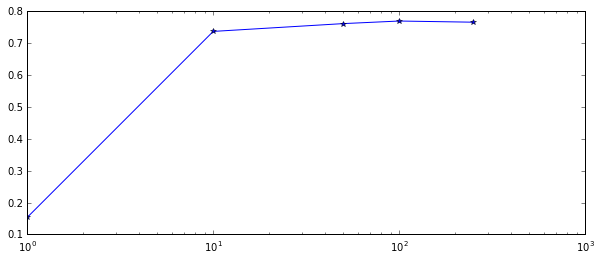

In [65]:
from sklearn.learning_curve import validation_curve

num_to_try = [1,10,50,100,250]
train_scores, valid_scores = validation_curve(RandomForestRegressor(), 
                                              data, price, 
                                              "n_estimators",
                                               num_to_try)

f, ax = plt.subplots(figsize=(10,4))
ax.semilogx(num_to_try, np.mean(valid_scores, axis=1),"-*")
f.show()

### grid search hyperparameters 

In [52]:
from sklearn.grid_search import GridSearchCV

# use a full grid over all parameters
param_grid = {"n_estimators" : [10,100],
              "max_depth": [5,8,15,30,None],
              "max_features": [2, None],
              "min_samples_split": [1, 2, 5, 10, 100],
              "min_samples_leaf": [1, 2, 5, 10],
              "bootstrap": [True, False]}
 
# run grid search
grid_search = GridSearchCV(rf, param_grid=param_grid, n_jobs=-1)
grid_search = grid_search.fit(data, price)

sorted_scores = sorted(grid_search.grid_scores_, key=lambda k: k.mean_validation_score, reverse=True)

[mean: 0.89113, std: 0.09709, params: {'bootstrap': False, 'n_estimators': 100, 'max_features': 2, 'max_depth': 30, 'min_samples_split': 1, 'min_samples_leaf': 1}]

In [53]:
print(sorted_scores[0:2])

[mean: 0.89199, std: 0.09522, params: {'bootstrap': False, 'n_estimators': 100, 'max_features': 2, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1}, mean: 0.89113, std: 0.09709, params: {'bootstrap': False, 'n_estimators': 100, 'max_features': 2, 'max_depth': 30, 'min_samples_split': 1, 'min_samples_leaf': 1}]


### Try SVM regressor 

In [19]:
from sklearn import svm
clf = svm.SVR()
clf.fit(data, price) 
scores = cross_validation.cross_val_score(clf, data, price)
print("scores =",scores)
print("avg accuracy = %4.2f" % scores.mean())

scores = [ 0.23739951  0.33218491  0.27264137]
avg accuracy = 0.28


### Try neural network 

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.cross_validation import cross_val_score

# define base mode
def model():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=num_features, init='normal', activation='relu'))
    model.add(Dense(20, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    return model

# evaluate model with standardized dataset
kr = KerasRegressor(build_fn=model, nb_epoch=100, batch_size=10, verbose=0)

scores = cross_val_score(kr, data, price, cv=3)
print("accuracy = %4.2f " % ((100 - scores.mean())/100) )


Using Theano backend.


accuracy = 0.48 
